## Visualizing intermediate activation in Convolutional Neural Networks

In [1]:
cd ../modules

/home/dadmaan/Documents/dev/py_music/music_classifier/modules


In [8]:
from instrument_classifier_m1 import ConvModel

import matplotlib.pyplot as plt
import numpy as np
np.set_printoptions(threshold=np.inf) # to remove the truncate threshold

import tensorflow as tf
import tensorflow_datasets as tfds

In [10]:
data = tfds.load(name='nsynth',
                     download=False,
                     try_gcs=True,
                     data_dir='/home/dadmaan/Seagate Backup Plus Drive/datasets/nsynth')

test_data = data['test']
test_data = test_data.map(lambda x: (x['audio'], x['instrument']['family']))
test_data = (test_data.batch(32).prefetch(tf.data.experimental.AUTOTUNE).repeat(1))

In [3]:
model = ConvModel()

model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['sparse_categorical_accuracy'])

In [11]:
layer_outputs = [layer.output for layer in model.layers[:12]]

activation_model = tf.keras.models.Model(inputs=model.input, outputs=layer_outputs)

In [12]:
activations = activation_model.predict(test_data.take(1))

In [14]:
first_layer_activation = activations[1]
print(first_layer_activation.shape)

(32, 124, 64, 1)


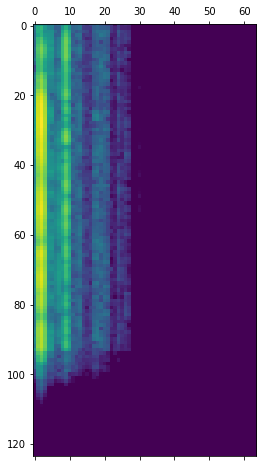

In [15]:
plt.matshow(first_layer_activation[1, :, :, 0], cmap='viridis')

In [ ]:
layer_names = []
for layer in model.layers[:12]:
    layer_names.append(layer.name) # Names of the layers, so you can have them as part of your plot
    
images_per_row = 16
for layer_name, layer_activation in zip(layer_names, activations): # Displays the feature maps
    n_features = layer_activation.shape[-1] # Number of features in the feature map
    size = layer_activation.shape[1] #The feature map has shape (1, size, size, n_features).
    n_cols = n_features // images_per_row # Tiles the activation channels in this matrix
    display_grid = np.zeros((size * n_cols, images_per_row * size))
    for col in range(n_cols): # Tiles each filter into a big horizontal grid
        for row in range(images_per_row):
            channel_image = layer_activation[0,
                                             :, :,
                                             col * images_per_row + row]
            channel_image -= channel_image.mean() # Post-processes the feature to make it visually palatable
            channel_image /= channel_image.std()
            channel_image *= 64
            channel_image += 128
            channel_image = np.clip(channel_image, 0, 255).astype('uint8')
            display_grid[col * size : (col + 1) * size, # Displays the grid
                         row * size : (row + 1) * size] = channel_image
    scale = 1. / size
    plt.figure(figsize=(scale * display_grid.shape[1],
                        scale * display_grid.shape[0]))
    plt.title(layer_name)
    plt.grid(False)
    plt.imshow(display_grid, aspect='auto', cmap='viridis')